In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

class UJIDataset(torch.utils.data.Dataset):
    def __init__(self, root, train = True, transform = None, target_transform = None, download = False):
        self.root = root
        dir_path = self.root + '/UJIndoorLoc'
        zip_path = self.root + '/uji_uil.zip'
        dataset_training_file = dir_path + '/trainingData.csv'
        dataset_validation_file = dir_path + '/validationData.csv'
        # Load independent variables (WAPs values)
        if train:
            dataset_file = dataset_training_file
        else:
            dataset_file = dataset_validation_file
        file = open(dataset_file, 'r')
        # Load independent variables
        file_load = np.loadtxt(file, delimiter = ',', skiprows = 1)
        self.x = file_load[:,0 : 520]
        # Load dependent variables
        self.y = file_load[:, 520:524]
        file.close()
        # Regularization of independent variables
        self.x[self.x == 100] = -104    # WAP not detected
        self.x = self.x + 104           # Convert into positive values
        self.x = self.x / 104           # Regularize into scale between 0 and 1
        # Reduce the number of dependent variables by combining building number and floor into one variable: area
        self.y[:, 2] = self.y[:, 3] * 5 + self.y[:, 2]
    def to_tensor(self):
        self.x = torch.from_numpy(self.x).float()
        self.y = torch.from_numpy(self.y).float()
    # Return the target instance (row)
    def __getitem__(self, index_row):
        return self.x[index_row, :], self.y[index_row, :]
    # Return the number of instances (the number of rows)
    def __len__(self, dim = 0):
        return int(self.x.size()[0])

We load the training dataset (`trainingData.csv`) and the test dataset (`validationData.csv`)

In [3]:
# Load training dataset
dataset_train = UJIDataset('./data', train = True)
dataset_train.to_tensor()
# Use only a part of trainingData.csv as a training set and the leftover as a validating set
training_size = int(0.8 * len(dataset_train))
indices = list(range(len(dataset_train)))
train_indices, validate_indices = indices[:training_size], indices[training_size:]
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
validate_sampler = torch.utils.data.sampler.SubsetRandomSampler(validate_indices)

# Load test dataset
dataset_test = UJIDataset('./data', train = False)
dataset_test.to_tensor()

The class `DelegateElectArea` is based on PCA.
It will be used to predict the building and the floor with the given input of RSSI values.

In [4]:
class DelegateElectArea(torch.nn.Module):
    def __init__(self):
        pass
    def train(self, x, y, delegate_num = 1):
        self.x_train = x
        self.y_train = y
        self.delegate_num = delegate_num
    # In this case, x_dim = 520 and y_range is within 0 and 15 (area)
    def naive_delegate(self, x_dim, y_range):
        # Construct weight_map of size y_range by x_dim
        self.weight_map = torch.zeros([y_range, x_dim], dtype = torch.float64)
        y_range_count = torch.ones([y_range])
        if self.delegate_num is 1:
            self.x_train_delegate_index = torch.argmax(self.x_train, dim = 1)
            # Update weight_map
            # Weight is 1
            for i in range(0, self.x_train_delegate_index.size()[0]):
                self.weight_map[int(self.y_train[i]), int(self.x_train_delegate_index[i])] += 1
                y_range_count[int(self.y_train[i])] += 1
            self.weight_map = self.weight_map / y_range_count[:, None]
        else:
            # Take all features that have non-zero values as delegates with corresponding weight (based on value)
            # self.x_train_delegate = self.x_train, no need to make a duplicate
            # Update weight_map
            # Weight is the RSSI value
            for i in range(0, self.x_train.size()[0]):
                self.weight_map[int(self.y_train[i]), :] += self.x_train[i, :]
                y_range_count[int(self.y_train[i])] += 1
            self.weight_map = self.weight_map / y_range_count[:, None]
    def softmax_delegate(self, x_dim, y_range):
        # Construct weight_map of size y_range by x_dim
        self.weight_map = torch.zeros([y_range, x_dim], dtype = torch.float64)
        y_range_count = torch.ones([y_range])
        softmax_row = torch.nn.Softmax(dim = 1)
        softmax_log = torch.nn.LogSoftmax(dim = 1)
        # Take all features that have non-zero values as delegates with corresponding weight (based on value)
        # self.x_train_delegate = self.x_train, no need to make a duplicate
        # Update weight_map
        # Applying softmax function on RSSI values for each instance
        for i in range(0, self.x_train.size()[0]):
            self.weight_map[int(self.y_train[i]), :] += (self.x_train[i, :])
            y_range_count[int(self.y_train[i])] += 1
        self.weight_map = self.weight_map / y_range_count[:, None]
        self.weight_map = softmax_row(self.weight_map)
    def elect(self, x_input_instance):
        # Calculate matrix multiplication of weight_map with x_input
        candidate = torch.matmul(self.weight_map.float(), (x_input_instance * 104).float())
        # Return the largest weight element's index from the candidate vector
        return torch.argmax(candidate).item()
    def evaluate(self, x_validate, y_validate):
        error_building = []
        error_floor = []
        for i in range(0, x_validate.size()[0]):
            prediction = self.elect(x_validate[i, :])
            if prediction != y_validate[i, 2]:
                error_floor.append(i)
            if int(prediction / 5) != int(y_validate[i, 2] / 5):
                error_building.append(i)
        error_rate_building = len(error_building) / x_validate.size()[0]
        error_rate_floor = len(error_floor) / x_validate.size()[0]
        print('error_rate_building: ', error_rate_building)
        print('error_rate_floor: ', error_rate_floor)

In [5]:
area_predictor = DelegateElectArea()
area_predictor.train(dataset_train.x[0 : training_size, :], dataset_train.y[0 : training_size, 2], delegate_num = 0)
area_predictor.softmax_delegate(x_dim = int(dataset_train.x.size()[1]), y_range = 15)
# Cross validation
area_predictor.evaluate(dataset_train.x[training_size : , :], dataset_train.y[training_size : ])

error_rate_building:  0.0025075225677031092
error_rate_floor:  0.18806419257773319


The function `euclidean_distance` takes two coordinates and returns the distance between the two.

In [6]:
# Calculate Euclidean distance (unit: meter) between two coordinates in EPSG:3857 
def euclidean_distance(latitude_1, longitude_1, latitude_2, longitude_2):
    return np.sqrt((latitude_1 - latitude_2)**2 + (longitude_1 - longitude_2)**2)

The class `DelegateElectLocation` is based on PCA.
It will be used to predict the location (latitude and longitude coordinates) with the given input of RSSI values.

In [7]:
class DelegateElectLocation():
    def __init(self):
        pass
    def train(self, x, y, delegate_num = 1):
        self.x = x
        self.y = y
        self.delegate_num = delegate_num
    def naive_delegate(self):
        # Take the leftmost, rightmost, lowermost and uppermost grid coordinates from the training data
        self.left_bound = self.y[torch.argmin(self.y[:, 0]).item(), 0].item()
        self.right_bound = self.y[torch.argmax(self.y[:, 0]).item(), 0].item()
        self.lower_bound = self.y[torch.argmin(self.y[:, 1]).item(), 1].item()
        self.upper_bound = self.y[torch.argmax(self.y[:, 1]).item(), 1].item()
        # Scale the coordinates to natural number of which the unit becomes (0.1m)
        column_num = int((right_bound - left_bound) * 10) + 1
        row_num = int((upper_bound - lower_bound) * 10) + 1
        # Construct the coordinates mapping matrix
        self.coordinate_map = torch.zeros([row_num, column_num], dtype = torch.float64)
        # Construct the correlation matrix of (longitude by RSSI values) and (latitude by RSSI values)
        self.longitude_weight_map = torch.zeros([column_num, self.x.size()[1]], dtype = torch.float64)
        self.latitude_weight_map = torch.zeros([row_num, self.x.size()[1]], dtype = torch.float64)
        longitude_count = torch.ones([column_num])
        latitude_count = torch.ones([row_num])
        # If we take only one representative (largest) element of each independent instance
        if self.delegate_num is 1:
            delegate_index = torch.argmax(self.x, dim = 1)
            for i in range(delegate_index.size()[0]):
                self.longitude_weight_map[int((self.y[i, 0] - self.left_bound) * 10), int(delegate_index[i])] += 1
                self.latitude_weight_map[int((self.y[i, 1] - self.lower_bound) * 10), int(delegate_index[i])] += 1
                longitude_count[int((self.y[i, 0] - self.left_bound) * 10)] += 1
                latitude_count[int((self.y[i, 1] - self.lower_bound) * 10)] += 1
                self.coordinate_map[int((self.y[i, 1] - self.lower_bound) * 10), int((self.y[i, 0] - self.left_bound) * 10)] += 1
        # If we take all elements of each independent instance with their corresponding weights
        else:
            for i in range(self.x.size()[0]):
                self.longitude_weight_map[int((self.y[i, 0] - self.left_bound) * 10), :] += self.x[i, :]
                self.latitude_weight_map[int((self.y[i, 1] - self.lower_bound) * 10), :] += self.x[i, :]
                longitude_count[int((self.y[i, 0] - self.left_bound) * 10)] += 1
                latitude_count[int((self.y[i, 1] - self.lower_bound) * 10)] += 1
                self.coordinate_map[int((self.y[i, 1] - self.lower_bound) * 10), int((self.y[i, 0] - self.left_bound) * 10)] += 1
        # Take means of each row of weight maps with corresponding counts
        self.longitude_weight_map /= longitude_count[:, None]
        self.latitude_weight_map /= latitude_count[:, None]
    # Same as naive_delegate function except that softmax_delegate function applies softmax function to the output weight maps
    def softmax_delegate(self):
        self.left_bound = self.y[torch.argmin(self.y[:, 0]).item(), 0].item()
        self.right_bound = self.y[torch.argmax(self.y[:, 0]).item(), 0].item()
        self.lower_bound = self.y[torch.argmin(self.y[:, 1]).item(), 1].item()
        self.upper_bound = self.y[torch.argmax(self.y[:, 1]).item(), 1].item()
        column_num = int((self.right_bound - self.left_bound) * 10) + 1
        row_num = int((self.upper_bound - self.lower_bound) * 10) + 1
        self.coordinate_map = torch.zeros([row_num, column_num], dtype = torch.float64)
        self.longitude_weight_map = torch.zeros([column_num, self.x.size()[1]], dtype = torch.float64)
        self.latitude_weight_map = torch.zeros([row_num, self.x.size()[1]], dtype = torch.float64)
        longitude_count = torch.ones([column_num])
        latitude_count = torch.ones([row_num])
        softmax_row = torch.nn.Softmax(dim = 1)
        softmax_log = torch.nn.LogSoftmax(dim = 1)
        # Take all features that have non-zero values as delegates with corresponding weight (based on value)
        # self.x_train_delegate = self.x_train, no need to make a duplicate
        # Update weight_map
        for i in range(self.x.size()[0]):
            self.longitude_weight_map[int((self.y[i, 0] - self.left_bound) * 10), :] += self.x[i, :]
            self.latitude_weight_map[int((self.y[i, 1] - self.lower_bound) * 10), :] += self.x[i, :]
            longitude_count[int((self.y[i, 0] - self.left_bound) * 10)] += 1
            latitude_count[int((self.y[i, 1] - self.lower_bound) * 10)] += 1
            self.coordinate_map[int((self.y[i, 1] - self.lower_bound) * 10), int((self.y[i, 0] - self.left_bound) * 10)] += 1
        self.longitude_weight_map /= longitude_count[:, None]
        self.latitude_weight_map /= latitude_count[:, None]
        # Applying softmax function on RSSI values for each instance
        self.longitude_weight_map = softmax_row(self.longitude_weight_map)
        self.latitude_weight_map = softmax_row(self.latitude_weight_map)
    def elect(self, x_input_instance):
        # Calculate matrix multiplication of weight_map with transpose of x_input
        longitude_candidate = torch.matmul(self.longitude_weight_map.float(), (x_input_instance * 104).float())
        latitude_candidate = torch.matmul(self.latitude_weight_map.float(), (x_input_instance * 104).float())
        # Return the largest weight element's index from the candidate vector
        return torch.argmax(latitude_candidate).item(), torch.argmax(longitude_candidate).item()
    def evaluate(self, x_validate, y_validate):
        error_distance = []
        for i in range(0, x_validate.size()[0]):
            latitude_prediction, longitude_prediction = self.elect(x_validate[i, :])
            # Rescale back to the original pseudo-mercator coordinates
            latitude_prediction = latitude_prediction / 10 + self.lower_bound
            longitude_prediction = longitude_prediction / 10 + self.left_bound
            # Push back the errors based on euclidean distance (unit: meter) for each prediction
            error_distance.append(euclidean_distance(y_validate[i, 1], y_validate[i, 0], latitude_prediction, longitude_prediction))
        # Take mean, max, min of all errors of distance
        error_mean_distance = torch.mean(torch.stack(error_distance)).item()
        error_max_distance = torch.max(torch.stack(error_distance)).item()
        error_min_distance = torch.min(torch.stack(error_distance)).item()
        error_std_distance = torch.std(torch.stack(error_distance)).item()
        error_var_distance = torch.var(torch.stack(error_distance)).item()
        print('error_mean_distance: ', error_mean_distance)
        print('error_max_distance: ', error_max_distance)
        print('error_min_distance: ', error_min_distance)
        print('error_std_distance: ', error_std_distance)
        print('error_var_distance: ', error_var_distance)
        #print('error_distance: ', error_distance)

In [8]:
location_predictor = DelegateElectLocation()
location_predictor.train(dataset_train.x[0:training_size, :], dataset_train.y[0:training_size, :], delegate_num = 0)
location_predictor.softmax_delegate()
# Cross validation
location_predictor.evaluate(dataset_train.x[training_size :, :], dataset_train.y[training_size :, :])

error_mean_distance:  15.561348915100098
error_max_distance:  252.39747619628906
error_min_distance:  0.00634765625
error_std_distance:  16.111896514892578
error_var_distance:  259.5932312011719


The real test with `validationData.csv` is as follows.

In [9]:
area_predictor = DelegateElectArea()
area_predictor.train(dataset_train.x, dataset_train.y[:, 2], delegate_num = 0)
area_predictor.softmax_delegate(x_dim = int(dataset_train.x.size()[1]), y_range = 15)
# Test (real validation)
area_predictor.evaluate(dataset_test.x, dataset_test.y)

error_rate_building:  0.0009000900090009
error_rate_floor:  0.15031503150315031


In [10]:
location_predictor = DelegateElectLocation()
location_predictor.train(dataset_train.x, dataset_train.y, delegate_num = 0)
location_predictor.softmax_delegate()
# Test (real validation)
location_predictor.evaluate(dataset_test.x, dataset_test.y)

error_mean_distance:  13.55756664276123
error_max_distance:  92.46202087402344
error_min_distance:  0.0302734375
error_std_distance:  10.330753326416016
error_var_distance:  106.72445678710938


tensor(7.)
tensor(7.)


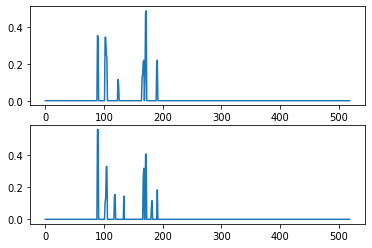

In [16]:
print(dataset_train.y[0, 2])
print(dataset_train.y[1, 2])
plt.subplot(2, 1, 1)
plt.plot(dataset_train.x[0, :])
plt.subplot(2, 1, 2)
plt.plot(dataset_train.x[1, :])

The following networks are for semi-supervised AAE (Adversarial Auto-Encoder), which needs more implementations.
It does not work at the moment.

In [12]:

# Encoder (Generator)
class NetQ(torch.nn.Module):
    def __init__(self, p = 0.0):
        super(NetQ, self).__init__()
        # global variables: x_dim = 520, y_dim = 2, h = 1000, z_dim = 5 
        self.lin_1_x = torch.nn.Linear(x_dim, h)
        self.lin_2_x = torch.nn.Linear(h, h)
        self.lin_3_gaussian = torch.nn.Linear(h, z_dim)
        self.lin_1_y = torch.nn.Linear(y_dim, h)
        self.lin_2_y = torch.nn.Linear(h, h)
        self.lin_3_regressive = torch.nn.Linear(h, y_dim)
        self.p = p
    # For Semi-supervised learning, y is added as an optional parameter
    def forward(self, x, y = None):
        #x = torch.nn.functional.dropout(self.lin_1_x(x), p = self.p, training = self.training)
        x = self.lin_1_x(x)
        x = torch.nn.functional.relu(x)
        #x = torch.nn.functional.dropout(self.lin_2_x(x), p = self.p, training = self.training)
        x = self.lin_2_x(x)
        x = torch.nn.functional.relu(x)
        z = self.lin_3_gaussian(x)
        if y is not None:
            #y = torch.nn.functional.dropout(self.lin_1_y(y), p = self.p, training = self.training)
            y = self.lin_1_y(y)
            y = torch.nn.functional.relu(y)
            #y = torch.nn.functional.dropout(self.lin_2_y(y), p = self.p, training = self.training)
            y = self.lin_2_y(y)
            y = torch.nn.functional.relu(y)
            y_fake = self.lin_3_regressive(y)
            return z, y_fake
        else:
            return z
    
# Decoder 
class NetP(torch.nn.Module):
    def __init__(self, p = 0.0):
        super(NetP, self).__init__()
        # global variables: x_dim = 520, y_dim = 2, h = 1000, z_dim = 5 
        self.lin_1 = torch.nn.Linear(z_dim, h)
        self.lin_2 = torch.nn.Linear(h, h)        
        self.lin_3 = torch.nn.Linear(h, x_dim)
        self.p = p
    # For Semi-supervised learning, y is added as an optional parameter
    def forward(self, x, y = None):
        if y is not None:
            x = torch.cat([x, y], 1)
        #x = torch.nn.functional.dropout(self.lin_1(x), p = self.p, training = self.training)
        x = self.lin_1(x)
        x = torch.nn.functional.relu(x)
        #x = torch.nn.functional.dropout(self.lin_2(x), p = self.p, training = self.training)
        x = self.lin_2(x)
        x = torch.nn.functional.relu(x)
        return self.lin_3(x)
    
# Gaussian Discriminator
class NetDGaussian(torch.nn.Module):
    def __init__(self, p = 0.0):
        super(NetDGaussian, self).__init__()
        # global variables: h = 1000, z_dim = 5 
        self.lin_1 = torch.nn.Linear(z_dim, h)
        self.lin_2 = torch.nn.Linear(h, h)
        self.lin_3 = torch.nn.Linear(h, 1)
        self.p = p
    def forward(self, x):
        #x = torch.nn.functional.dropout(self.lin_1(x), p = self.p, training = self.training)
        x = self.lin_1(x)
        x = torch.nn.functional.relu(x)
        #x = torch.nn.functional.dropout(self.lin_2(x), p = self.p, training = self.training)
        x = self.lin_2(x)
        x = torch.nn.functional.relu(x)
        return torch.softmax(self.lin_3(x), dim = 1)
        
# Regressive Discriminator
class NetDRegressive(torch.nn.Module):
    # parameter d represents distance criterion
    def __init__(self, p = 0.0, d = 0.0):
        super(NetDRegressive, self).__init__()
        # global variables: y_dim = 2, h = 1000, z_dim = 5 
        self.lin_1 = torch.nn.Linear(y_dim, h)
        self.lin_2 = torch.nn.Linear(h, h)
        self.lin_3 = torch.nn.Linear(h, 1)
        self.p = p
    def forward(self, x):
        #x = torch.nn.functional.dropout(self.lin_1(x), p = self.p, training = self.training)
        x = self.lin_1(x)
        x = torch.nn.functional.relu(x)
        #x = torch.nn.functional.dropout(self.lin_2(x), p = self.p, training = self.training)
        x = self.lin_2(x)
        x = torch.nn.functional.relu(x)
        return torch.softmax(self.lin_3(x), dim = 1)
        

In [13]:
# Set dimensions and parameters
x_dim = dataset_train.x.size()[1]    # 520
y_dim = 2                      # longitude and latitude
z_dim = 5                      # latent variable dimension
h = 1000                       # hidden layer dimension
batch_size = 200
n_epochs = 100

torch.manual_seed(10)
# Construct network layers
Q = NetQ(p = 0.0)                  # Encoder (Generator)
P = NetP(p = 0.0)                  # Decoder
DG = NetDGaussian(p = 0.0)          # Discriminator adversarial
DR = NetDRegressive(p = 0.0, d = 1) # Discriminator regressive
# Activate CUDA if available
if torch.cuda.is_available():
    P = P.cuda()
    Q = Q.cuda()
    DG = DG.cuda()
    DR = DR.cuda()
# Set learning rate
gen_lr, reg_lr = 0.0006, 0.0008
# Set optimizers
Q_encoder = torch.optim.Adam(Q.parameters(), lr = gen_lr)
Q_generator = torch.optim.Adam(Q.parameters(), lr = reg_lr)
P_decoder = torch.optim.Adam(P.parameters(), lr = gen_lr)
DG_solver = torch.optim.Adam(DG.parameters(), lr = reg_lr)
DR_solver = torch.optim.Adam(DR.parameters(), lr = reg_lr)